# Modeling and Simulation in Python

Richard Gao


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from matplotlib import patches
import math

## Asteroid Data 

https://cneos.jpl.nasa.gov/sentry/details.html#?des=410777

We are simulating a real life asteroid that has relatively high possiblity of hitting earth if any.

## Assumptions

Rocket has enough ionic fuel to keep from crashing into the asteroid indefinitely.
Spaceship is able to constantly apply a 5.4N force on the asteroid.
Assume that the tractor is applying an average force in one direction. We are abstracting the 3D motion to 2D.

Asteroid is orbiting around the earth and sun


In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [3]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

# asteroid is two times the distance from earth to sun
init_x_asteroid = 147e9 * 2 * m
init_y_asteroid = 0 * m

init = State(x_earth=r_0,
             y_earth=0 * m,
             vx_earth=0 * m / s,
             vy_earth=-30330 * m / s,
             x_asteroid=init_x_asteroid,
             y_asteroid=init_y_asteroid,
             vx_asteroid=0 * m / s,
             vy_asteroid=15.87e3 * m / s)

,values
x_earth,147000000000.0 meter
y_earth,0 meter
vx_earth,0.0 meter / second
vy_earth,-30330.0 meter / second
x_asteroid,294000000000.0 meter
y_asteroid,0 meter
vx_asteroid,0.0 meter / second
vy_asteroid,15870.0 meter / second


In [4]:
# Making a system object

# displacement from initial position of asteroid to the sun
dis_init_asteroid = Vector(init_x_asteroid, init_y_asteroid)

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m_sun=1.989e30 * kg,
                m_earth=5.972e24 * kg,
                m_asteroid=3.2e9 * kg,
                r_earth=6.371e6 * m,
                r_asteroid=0.472e3 / 2 * m,
                dis_init_asteroid=dis_init_asteroid,
                t_0=0 * s,
                t_end=2 * UNITS.year)

,values
init,x_earth 147000000000.0 meter y_earth...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_sun,1.989e+30 kilogram
m_earth,5.972e+24 kilogram
m_asteroid,3200000000.0 kilogram
r_earth,6371000.0 meter
r_asteroid,236.0 meter
dis_init_asteroid,"[294000000000.0 meter, 0.0 meter]"
t_0,0 second
t_end,2 year


In [5]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)
    
    displacement = Vector(x_earth, y_earth)
    
    force = G * m_sun * m_earth / displacement.mag**2

    return displacement.hat() * force 

In [6]:
universal_gravitation(init, system)

<Quantity([3.6686486e+22 0.0000000e+00], 'newton')>

In [7]:
def get_displacement(a, b):
    """Returns the displacement between two vector objects
    
    a: object 1
    b: object 2 
    
    returns: displacement between objects
    """
    return a - b

In [8]:
def force_on_asteroid(state, system):
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)
    
    displacement_s_e = Vector(x_earth, y_earth)
    displacement_s_a = Vector(x_asteroid, y_asteroid)
    
    # Get distance between earth and asteroid
    displacement_e_a = get_displacement(displacement_s_e, displacement_s_a)
    
    force_sun = displacement_s_a.hat() * (G * m_sun * m_asteroid / displacement_s_a.mag**2)
    force_earth = displacement_e_a.hat() * (G * m_earth * m_asteroid / displacement_e_a.mag**2)
    
    return force_sun + force_earth

In [9]:
# The slope function

def slope_func(state, t, system):
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)    

    force_earth = -universal_gravitation(state, system)
    
    dvxdt_earth = force_earth.x / m_earth
    dvydt_earth = force_earth.y / m_earth
    
    force_asteroid = -force_on_asteroid(state, system)
    
    dvxdt_asteroid = force_asteroid.x / m_asteroid
    dvydt_asteroid = force_asteroid.y / m_asteroid
    
    return vx_earth, vy_earth, dvxdt_earth, dvydt_earth, vx_asteroid, vy_asteroid, dvxdt_asteroid, dvydt_asteroid 

In [10]:
slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-30330.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(15870.0, 'meter / second')>,
 <Quantity(-0.00153575206759776, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

## Introduce Event Function to see if asteroid hits

In [11]:
def event_func(state, t, system):
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)

    result = 1

    # Test if asteroid hits earth with radius into account with tolerance of 10 million km
    if get_displacement(Vector(x_earth, y_earth), Vector(x_asteroid, y_asteroid)).mag < r_earth + r_asteroid + 10e9:
        print('HITS EARTH!! MAYDAY!')
        result = 0
    
    return result

In [12]:
results, details = run_ode_solver(system, slope_func, max_step=20*UNITS.day, events=event_func, method='RK23')

In [13]:
details

,values
sol,None
t_events,[[]]
nfev,221
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [14]:
results.tail()

,x_earth,y_earth,vx_earth,vy_earth,x_asteroid,y_asteroid,vx_asteroid,vy_asteroid
5.711650e+07,4.215781e+10,1.427749e+11,28606.228800,-9065.393827,2.555993e+11,1.057194e+11,-10877.262938,13775.309750
5.846905e+07,7.885242e+10,1.254746e+11,25255.612345,-16456.996489,2.394172e+11,1.236943e+11,-13059.678189,12762.265072
6.012094e+07,1.155325e+11,9.194853e+10,18580.241147,-23876.497660,2.156242e+11,1.435249e+11,-15761.820128,11171.080703
6.184894e+07,1.400828e+11,4.599253e+10,9331.444213,-28826.614622,1.859300e+11,1.610408e+11,-18620.213412,8995.081968
6.311385e+07,1.471894e+11,8.422577e+09,1758.519180,-30250.951214,1.610551e+11,1.711935e+11,-20712.783840,6986.554844


In [15]:
# Scaling the time steps to days
results.index /= 60 * 60 * 24

In [16]:
# Scaling the distance to million km
x_earth = results.x_earth / 1e9;
y_earth = results.y_earth / 1e9;

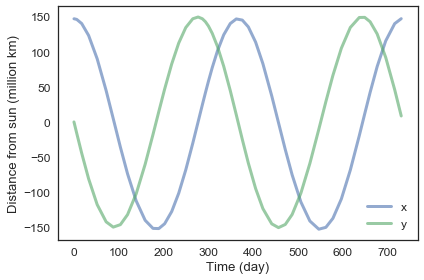

In [17]:
plot(x_earth, label='x')
plot(y_earth, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

In [18]:
#Scaling the distance to million km
x_asteroid = results.x_asteroid / 1e9;
y_asteroid = results.y_asteroid / 1e9;

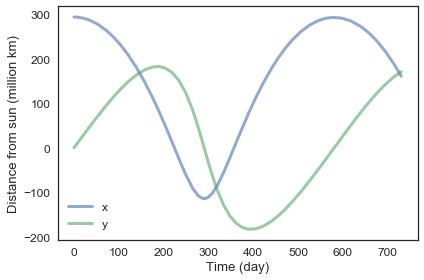

In [19]:
plot(x_asteroid, label='x')
plot(y_asteroid, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

In [20]:
def plot_orbit(results):   
    # Scaling the distance to million km
    x_earth = results.x_earth / 1e9;
    y_earth = results.y_earth / 1e9;
    
    #Scaling the distance to million km
    x_asteroid = results.x_asteroid / 1e9;
    y_asteroid = results.y_asteroid / 1e9;
    
    plot(x_earth, y_earth, label='earth')
    plot(x_asteroid, y_asteroid, label='asteroid')

    # Plot end points of earth and asteroid orbit
    plot(results.x_earth.values[-1] / 1e9, results.y_earth.values[-1] / 1e9, 'ob')
    plot(results.x_asteroid.values[-1] / 1e9, results.y_asteroid.values[-1] / 1e9, 'og')

    # Plot sun as a circle with realistic radius
    ax = plt.gca()

    # Plot realistic sun size
    # circle = patches.Circle((0,0), radius=.695, color='orange')

    circle = patches.Circle((0,0), radius=10, color='orange')
    elements = [circle]
    ax.add_patch(circle)

    decorate(xlabel='x (million km)',
             ylabel='y (million km)',
             loc='upper center')

    # Plot with equal aspect ratio
    ax.set_aspect('equal')

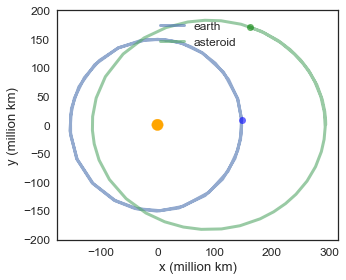

In [21]:
plot_orbit(results)

## Finding period

In [22]:
distances = TimeSeries()
# Flag to check if asteroid has left bounding box
left_box = False

def event_func_period(state, t, system):
    global left_box
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)
    print('Earth: (' + str(x_earth) + ', ' + str(y_earth) + ')', 'Asteroid: (' + str(x_asteroid) + ', ' + str(y_asteroid) + ')' )
    
    result = 1
    
    # Get distance of asteroid from initial position in orbit, scale to million km
    distance = get_displacement(Vector(x_asteroid, y_asteroid), dis_init_asteroid).mag / 1e9
    distances[str(t)] = distance
    
    # If asteroid is back within 10 million km of it initial bounding box
    if distance < 10:
        if left_box:
            print('################\nIn bounding box of 100 km', 'Distance: ' + str(distance * UNITS.m),
                  'Time: ' + str(t)+ '\n################')
            result = 0
    elif not left_box:
        print("################\nAsteroid left bounding box. It's in orbit.\n################")
        left_box = True
    
    return result

In [23]:
results, details = run_ode_solver(system, slope_func, max_step=20*UNITS.day, events=event_func_period, method='RK23')

Earth: (147000000000.0, 0) Asteroid: (294000000000.0, 0)
Earth: (147000000000.0, -0.0017720745419411387) Asteroid: (294000000000.0, 0.000927227925506293)
Earth: (147000000000.0, -0.019492819961352527) Asteroid: (294000000000.0, 0.010199507180569223)
Earth: (147000000000.0, -0.19670027415546637) Asteroid: (294000000000.0, 0.10292229973119853)
Earth: (147000000000.0, -1.968774816096605) Asteroid: (294000000000.0, 1.0301502252374914)
Earth: (147000000000.0, -19.689520235507995) Asteroid: (294000000000.0, 10.302429480300423)
Earth: (147000000000.0, -196.89697442962188) Asteroid: (294000000000.0, 103.02522203092974)
Earth: (147000000000.0, -1968.9715163707604) Asteroid: (294000000000.0, 1030.253147537223)
Earth: (146999999999.99872, -19689.716935782086) Asteroid: (293999999999.9997, 10302.53240260015)
Earth: (146999999999.87057, -196897.17112983819) Asteroid: (293999999999.96765, 103025.32495322569)
Earth: (146999999987.05536, -1968971.7130132394) Asteroid: (293999999996.7639, 1030253.25045

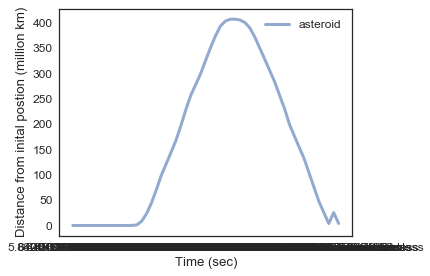

In [24]:
plot(distances, label='asteroid')
decorate(xlabel='Time (sec)',
         ylabel='Distance from inital postion (million km)')

In [25]:
t_final = get_last_label(results) * s

<Quantity(49940928.32694052, 'second')>

In [26]:
period = t_final.to(UNITS.day)

<Quantity(578.0200037840337, 'day')>

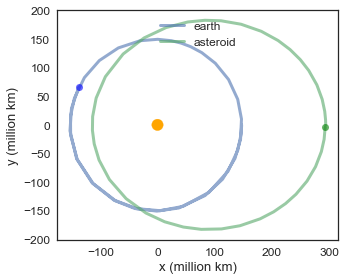

In [27]:
plot_orbit(results)

## Running Simulation for Multiple Periods to Test if Asteroid Will Hit (50 periods)

In [61]:
system.t_end = 50 * period
system

,values
init,x_earth 147000000000.0 meter y_earth...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_sun,1.989e+30 kilogram
m_earth,5.972e+24 kilogram
m_asteroid,3200000000.0 kilogram
r_earth,6371000.0 meter
r_asteroid,236.0 meter
dis_init_asteroid,"[294000000000.0 meter, 0.0 meter]"
t_0,0 second
t_end,28901.000189201688 day


In [29]:
results, details = run_ode_solver(system, slope_func, max_step=20*UNITS.day, events=event_func, method='RK23')

HITS EARTH!! MAYDAY!
HITS EARTH!! MAYDAY!


In [30]:
details

,values
sol,None
t_events,[[1153785548.8917234]]
nfev,3341
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [31]:
results.tail()

,x_earth,y_earth,vx_earth,vy_earth,x_asteroid,y_asteroid,vx_asteroid,vy_asteroid
1.147441e+09,-1.548092e+11,4.485750e+10,8160.083375,27389.034901,1.441112e+11,1.710751e+11,-21559.408957,7555.678849
1.148953e+09,-1.370934e+11,8.418227e+10,15214.541213,24257.283336,1.096154e+11,1.800037e+11,-24039.554874,4105.803389
1.150681e+09,-1.048135e+11,1.215279e+11,21943.964754,18507.176882,6.591724e+10,1.829684e+11,-26446.069123,-928.069289
1.152409e+09,-6.255676e+10,1.473015e+11,26628.414271,10942.023923,1.875888e+10,1.760518e+11,-27929.239103,-7399.983125
1.153786e+09,-2.436691e+10,1.577487e+11,28575.419278,4075.567820,-1.982721e+10,1.616636e+11,-27874.859135,-13723.553607


In [32]:
# Scaling the time steps to days
results.index /= 60 * 60 * 24

In [33]:
# Scaling the distance to million km
x_earth = results.x_earth / 1e9;
y_earth = results.y_earth / 1e9;

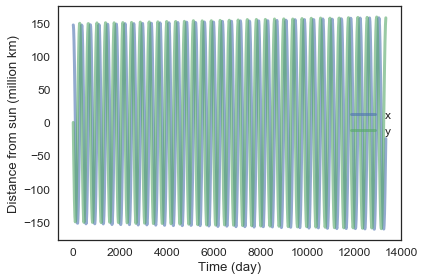

In [34]:
plot(x_earth, label='x')
plot(y_earth, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

In [35]:
#Scaling the distance to million km
x_asteroid = results.x_asteroid / 1e9;
y_asteroid = results.y_asteroid / 1e9;

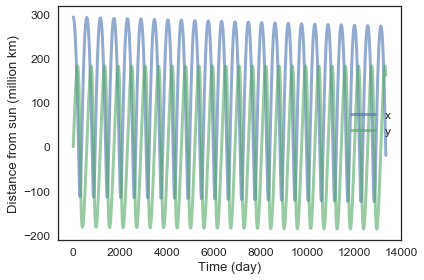

In [36]:
plot(x_asteroid, label='x')
plot(y_asteroid, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

In [37]:
t_final = get_last_label(results) * UNITS.days

<Quantity(13353.99940846902, 'day')>

In [38]:
# Time for asteroid collides with earth
t_final.to(UNITS.year)

<Quantity(36.5620387048074, 'year')>

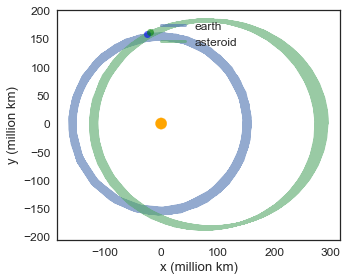

In [39]:
plot_orbit(results)

## Implement Gravity Tractor

In [54]:
# Time set to a little greater than collision time to see the trajectory of asteroid after it passes earth
system.t_end = 36.5620387048074 * UNITS.year
system

,values
init,x_earth 147000000000.0 meter y_earth...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_sun,1.989e+30 kilogram
m_earth,5.972e+24 kilogram
m_asteroid,3200000000.0 kilogram
r_earth,6371000.0 meter
r_asteroid,236.0 meter
dis_init_asteroid,"[294000000000.0 meter, 0.0 meter]"
t_0,0 second
t_end,36.5620387048074 year


In [62]:
# Mass of largest spaceship in existence currently, plz link source
m_spaceship = 6.91e3 * kg
# Greatest force produced by an ion thrusted satellite, plz link source
force_spaceship = 5.4 * N
# Distance that spaceship has to maintain away from asteroid to keep system in equilibrium
r = (G * m_asteroid * m_spaceship / force_spaceship) ** .5

<Quantity(16.53142282868419, 'meter')>

In [63]:
def slope_func(state, t, system):
    x_earth, y_earth, vx_earth, vy_earth, x_asteroid, y_asteroid, vx_asteroid, vy_asteroid = state
    unpack(system)    

    force_earth = -universal_gravitation(state, system)
    
    dvxdt_earth = force_earth.x / m_earth
    dvydt_earth = force_earth.y / m_earth
    
    force_asteroid = -force_on_asteroid(state, system)
    
    dvxdt_asteroid = force_asteroid.x / m_asteroid
    # Takes into account the force the spaceship (gravity tractor) exerts on the asteroid
    dvydt_asteroid = (force_asteroid.y - force_spaceship) / m_asteroid
    
    return vx_earth, vy_earth, dvxdt_earth, dvydt_earth, vx_asteroid, vy_asteroid, dvxdt_asteroid, dvydt_asteroid 

In [64]:
results, details = run_ode_solver(system, slope_func, max_step=20*UNITS.day, events=event_func, method='RK23')

In [65]:
details

,values
sol,None
t_events,[[]]
nfev,6773
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [66]:
# Scaling the time steps to days
results.index /= 60 * 60 * 24

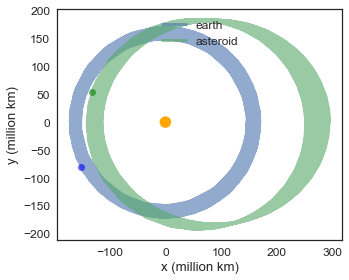

In [67]:
plot_orbit(results)